# Evaluating Word Representations

## Getting the pre-trained word vectors

In [128]:
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

In [5]:
bow2_file = 'bow2.words'
bow5_file = 'bow5.words'
dependency_file = 'deps.words'

#read the files
with open(bow2_file) as f:
    bow2 = f.readlines()
    
with open(bow5_file) as f:
    bow5 = f.readlines()
    
with open(dependency_file) as f:
    dependency = f.readlines()
  

In [6]:
print(len(bow2))
print(len(bow5))
print(len(dependency))

183870
183870
174015


In [7]:
word2 = []
word5 = []
word_deps = []

vector2 = dict()
vector5 = dict()
vector_deps = dict()

In [8]:
#fill in the word arrays and the respective vector arrays

#bow2
for l in bow2:
    #split line
    split_line = str.split(l)
    
    #first one is the word - string
    word = split_line[0]
    word2.append(word)
    
    #remaining elements are the embedding values - float
    vector = []
    for vd in split_line[1:]:
        vector.append(float(vd))
        
    vector2[word] = vector
    

In [9]:
#bow5
for l in bow5:
    #split line
    split_line = str.split(l)
    
    #first one is the word - string
    word = split_line[0]
    word5.append(word)
    
    #remaining elements are the embedding values - float
    vector = []
    for vd in split_line[1:]:
        vector.append(float(vd))
        
    vector5[word] = vector

In [10]:
#dependency
for l in dependency:
    #split line
    split_line = str.split(l)
    
    #first one is the word - string
    word = split_line[0]
    word_deps.append(word)
    
    #remaining elements are the embedding values - float
    vector = []
    for vd in split_line[1:]:
        vector.append(float(vd))
        
    vector_deps[word] = vector

In [11]:
print(word2[0])
print(word5[0])
print(word_deps[0])


the
the
the


In [12]:
print(len(vector2['the']))
print(len(vector5['the']))
print(len(vector_deps['the']))


300
300
300


## Word Similarity Task

In [192]:
#MEN/agreement/elias-men-ratings.txt' dataset read
word_pairs = {}

filename = 'MEN/MEN_dataset_natural_form_full'

with open(filename) as f:
    lines = f.readlines()
    
for line in lines:
    line = line.split()
    word1 = line[0]
    word2 = line[1]
    score = line[2]
    word_pairs[(word1,word2)] = score
    
keys = list(word_pairs.keys())

In [205]:
def get_scores_cosines(keys, word_pairs, vector_embeds, norm_min, norm_max):
    #vector_deps and cosine similarity comparison
    scores = []
    cosines = []

    for key in keys:
        word1 = key[0]
        word2 = key[1]
        score = word_pairs[(word1,word2)]
        score = (float(score) - norm_min)/(norm_max - norm_min) #normalization
        if word1 in vector_embeds.keys() and word2 in vector_embeds.keys():
            word1_embed = vector_embeds[word1]
            word2_embed = vector_embeds[word2]
            
            cosine_similarity = 1 - spatial.distance.cosine(word1_embed, word2_embed)
#             print("Score : ",score)
#             print("Cosine similarity: ",cosine_similarity)
#             print(word1, word2)
#             print("\n")
            
            scores.append(score)
            cosines.append(cosine_similarity)
            
            
    return scores, cosines
        

In [206]:
norm_max = 50 #for MEN
norm_min = 0 #for MEN

#vector2 and cosine similarity comparison
scores_2, cosines_2 = get_scores_cosines(keys, word_pairs, vector2, norm_min, norm_max)

#vector5 and cosine similarity comparison
scores_5, cosines_5 = get_scores_cosines(keys, word_pairs, vector5, norm_min, norm_max)

#vector2 and cosine similarity comparison
scores_deps, cosines_deps = get_scores_cosines(keys, word_pairs, vector_deps, norm_min, norm_max)

In [207]:
def get_stats(cosines_2, scores_2, cosines_5, scores_5, cosines_deps, scores_deps):
    cosines_2 = np.asarray(cosines_2)
    cosines_5 = np.asarray(cosines_5)
    cosines_deps = np.asarray(cosines_deps)

    mean_cos_2 = np.mean(cosines_2)
    std_cos_2 = np.std(cosines_2)

    mean_cos_5 = np.mean(cosines_5)
    std_cos_5 = np.std(cosines_5)

    mean_cos_deps = np.mean(cosines_deps)
    std_cos_deps= np.std(cosines_deps)

    print('Means and stds')
    print('Bow2:',mean_cos_2, std_cos_2)
    print('Bow5:',mean_cos_5, std_cos_5)
    print('Deps:',mean_cos_deps, std_cos_deps)
    
    print()
    
    #normality tests means sds
    print('Normality tests')
    print('Bow2 scores:',stats.normaltest(scores_2)[1])
    print('Bow5 scores:',stats.normaltest(scores_5)[1])
    print('Deps scores:',stats.normaltest(scores_deps)[1])
    print()
    print('Bow2 cosines:',stats.normaltest(cosines_2)[1])
    print('Bow5 cosines:',stats.normaltest(cosines_5)[1])
    print('Deps cosines:',stats.normaltest(cosines_deps)[1])
    print()
    
    #difference between the embed types cosine similarities
    print('T-test between Bow2 and Bow5')
    print(stats.ttest_ind(cosines_2, cosines_5)[1])
    print('T-test between Bow2 and Dependency')
    print(stats.ttest_ind(cosines_2, cosines_deps)[1])
    print('T-test between Dependency and Bow2')
    print(stats.ttest_ind(cosines_deps, cosines_5)[1])
    print()
    
    #difference between the embed types cosine similarities vs human ratings
    print('T-test between Bow2 and human scores')
    print(stats.ttest_ind(cosines_2, scores_2)[1])
    print('T-test between Bow5 and human scores')
    print(stats.ttest_ind(cosines_5, scores_5)[1])
    print('T-test between Dependency and human scores')
    print(stats.ttest_ind(cosines_deps, scores_deps)[1])
    print()
    
    #correlation tests for bow2
    pr_2, sig_p_2 = pearsonr(scores_2, cosines_2)
    spr_2, sig_s_2 = spearmanr(scores_2, cosines_2)

    print('Correlation results for BOW2 vs. human ratings')
    print('Pearson\'s r:',pr_2, 'p-value =', sig_p_2)
    print('Spearman\'s r:',spr_2, 'p-value =', sig_s_2)
    print()
    ###

    #correlation tests for bow5
    pr_5, sig_p_5 = pearsonr(scores_5, cosines_5)
    spr_5, sig_s_5 = spearmanr(scores_5, cosines_5)

    print('Correlation results for BOW5 vs. human ratings')
    print('Pearson\'s r:',pr_5, 'p-value =', sig_p_5)
    print('Spearman\'s r:',spr_5, 'p-value =', sig_s_5)
    print()

    ###
    #correlation tests for dependency
    pr_deps, sig_p_deps = pearsonr(scores_deps, cosines_deps)
    spr_deps, sig_s_deps = spearmanr(scores_deps, cosines_deps)

    print('Correlation results for Dependency vs. human ratings')
    print('Pearson\'s r:',pr_deps, 'p-value =', sig_p_deps)
    print('Spearman\'s r:',spr_deps, 'p-value =', sig_s_deps)

In [208]:
len(cosines_2)

3000

In [209]:
print('***Stats for MEN natural form***')
get_stats(cosines_2, scores_2, cosines_5, scores_5, cosines_deps, scores_deps)

***Stats for MEN natural form***
Means and stds
Bow2: 0.319293299756 0.149208353164
Bow5: 0.311801651032 0.191357815617
Deps: 0.397603289218 0.151686067678

Normality tests
Bow2 scores: 0.0
Bow5 scores: 0.0
Deps scores: 0.0

Bow2 cosines: 2.26058583686e-25
Bow5 cosines: 2.67202826149e-47
Deps cosines: 1.41622916781e-31

T-test between Bow2 and Bow5
0.0909373707275
T-test between Bow2 and Dependency
1.80166193092e-87
T-test between Dependency and Bow2
4.06219028985e-80

T-test between Bow2 and human scores
3.23549291582e-237
T-test between Bow5 and human scores
7.60142658496e-221
T-test between Dependency and human scores
1.01459133734e-81

Correlation results for BOW2 vs. human ratings
Pearson's r: 0.67769822447 p-value = 0.0
Spearman's r: 0.699904755831 p-value = 0.0

Correlation results for BOW5 vs. human ratings
Pearson's r: 0.708236248047 p-value = 0.0
Spearman's r: 0.723168656137 p-value = 0.0

Correlation results for Dependency vs. human ratings
Pearson's r: 0.597401604467 p-valu

In [213]:
#lemmatized MEN, which includes POS-tags and words with inflections 

word_pairs = {}
pos_tag_pairs = {}

filename = 'MEN/MEN_dataset_lemma_form_full'

with open(filename) as f:
    lines = f.readlines()
    
for line in lines:
    line = line.split()
    
    word_pos_1 = line[0]
    split_wp = word_pos_1.split('-')
    word1 = split_wp[0]
    pos1 = split_wp[1]
    
    word_pos_2 = line[1]
    split_wp = word_pos_2.split('-')
    word2= split_wp[0]
    pos2 = split_wp[1]
    
    score = line[2]
    word_pairs[(word1,word2)] = score
    pos_tag_pairs[(word1, word2)] = (pos1, pos2)
    
keys = list(word_pairs.keys())

In [214]:
keys[0]

('sun', 'sunlight')

In [215]:
pos_tag_pairs[('sun', 'sunlight')]

('n', 'n')

In [216]:
len(cosines_2)

3000

In [ ]:
vector2['stairs'] #natural form exists in the embeddings

In [217]:
#vector2 and cosine similarity comparison
scores_2, cosines_2 = get_scores_cosines(keys, word_pairs, vector2, norm_min, norm_max)

#vector5 and cosine similarity comparison
scores_5, cosines_5 = get_scores_cosines(keys, word_pairs, vector5, norm_min, norm_max)

#vector2 and cosine similarity comparison
scores_deps, cosines_deps = get_scores_cosines(keys, word_pairs, vector_deps, norm_min, norm_max)

print('***Stats for MEN lemma form***')
get_stats(cosines_2, scores_2, cosines_5, scores_5, cosines_deps, scores_deps)

***Stats for MEN lemma form***
Means and stds
Bow2: 0.316803512667 0.145607303311
Bow5: 0.308255587339 0.186932626717
Deps: 0.403399757048 0.149368049522

Normality tests
Bow2 scores: 0.0
Bow5 scores: 0.0
Deps scores: 0.0

Bow2 cosines: 4.79219186707e-25
Bow5 cosines: 5.29522735224e-57
Deps cosines: 4.32604518066e-30

T-test between Bow2 and Bow5
0.0482493426745
T-test between Bow2 and Dependency
8.03242845857e-110
T-test between Dependency and Bow2
3.04144684951e-101

T-test between Bow2 and human scores
0.0
T-test between Bow5 and human scores
0.0
T-test between Dependency and human scores
0.0

Correlation results for BOW2 vs. human ratings
Pearson's r: 0.669495069415 p-value = 0.0
Spearman's r: 0.686061690441 p-value = 0.0

Correlation results for BOW5 vs. human ratings
Pearson's r: 0.703135928466 p-value = 0.0
Spearman's r: 0.715675453077 p-value = 0.0

Correlation results for Dependency vs. human ratings
Pearson's r: 0.58814663439 p-value = 1.06640642166e-278
Spearman's r: 0.60553

In [187]:
#TODO SOMETHING ABOUT POS-TAGS *** 

In [188]:
# Simlex Dataset Read

word_pairs = {}

filename = 'SimLex-999/SimLex-999.txt'

with open(filename) as f:
    lines = f.readlines()
    
lines = lines[1:]
for line in lines:
    line = line.split()
    word1 = line[0]
    word2 = line[1]
    score = line[3]
    word_pairs[(word1,word2)] = score
    
keys = list(word_pairs.keys())

In [212]:
norm_min = 0 #For SimLex
norm_max = 10 #For SimLex

#vector2 and cosine similarity comparison
scores_2, cosines_2 = get_scores_cosines(keys, word_pairs, vector2, norm_min, norm_max)

#vector5 and cosine similarity comparison
scores_5, cosines_5 = get_scores_cosines(keys, word_pairs, vector5, norm_min, norm_max)

#vector2 and cosine similarity comparison
scores_deps, cosines_deps = get_scores_cosines(keys, word_pairs, vector_deps, norm_min, norm_max)

print('***Stats for SimLex***')
get_stats(cosines_2, scores_2, cosines_5, scores_5, cosines_deps, scores_deps)

***Stats for SimLex***
Means and stds
Bow2: 0.316803512667 0.145607303311
Bow5: 0.308255587339 0.186932626717
Deps: 0.403399757048 0.149368049522

Normality tests
Bow2 scores: 0.0
Bow5 scores: 0.0
Deps scores: 0.0

Bow2 cosines: 4.79219186707e-25
Bow5 cosines: 5.29522735224e-57
Deps cosines: 4.32604518066e-30

T-test between Bow2 and Bow5
0.0482493426745
T-test between Bow2 and Dependency
8.03242845857e-110
T-test between Dependency and Bow2
3.04144684951e-101

T-test between Bow2 and human scores
0.0
T-test between Bow5 and human scores
0.0
T-test between Dependency and human scores
0.0

Correlation results for BOW2 vs. human ratings
Pearson's r: 0.669495069415 p-value = 0.0
Spearman's r: 0.686061690441 p-value = 0.0

Correlation results for BOW5 vs. human ratings
Pearson's r: 0.703135928466 p-value = 0.0
Spearman's r: 0.715675453077 p-value = 0.0

Correlation results for Dependency vs. human ratings
Pearson's r: 0.58814663439 p-value = 1.06640642166e-278
Spearman's r: 0.605532590481 

In [ ]:
#todo something about adjective nouns etc

## Word Analogy Task

In [28]:
analogy_file = 'questions-words.txt'

#read the files
with open(analogy_file) as f:
    analogies = f.readlines()
    
for a in analogies:
    if ':' in a:
        print(a)

: capital-common-countries

: capital-world

: currency

: city-in-state

: family

: gram1-adjective-to-adverb

: gram2-opposite

: gram3-comparative

: gram4-superlative

: gram5-present-participle

: gram6-nationality-adjective

: gram7-past-tense

: gram8-plural

: gram9-plural-verbs



In [29]:
# all types of analogies
all_analogy_pairs = []

#they are also stored separately
capital_common_countries = []
capital_world = []
currency = []
city_in_state = []
family = []
gram1_adjective_to_adverb = []
gram2_opposite = []
gram3_comparative = []
gram4_superlative = []
gram5_present_participle = []
gram6_nationality_adjective = []
gram7_past_tense = []
gram8_plural = []
gram9_plural_verbs = []

#while reading into the arrays, keep the current array
current = []

for i in range(len(analogies)):
    #one line -> question-answer pair
    a = analogies[i]
    
    if ': capital-common-countries' in a:
        continue
    elif ': capital-world' in a:

        #store current array
        capital_common_countries = current

        #reset current
        current = []  
        continue
    elif ': currency' in a:

        #store current array
        capital_world = current

        #reset current
        current = []  
        continue
    elif ': city-in-state' in a:

        #store current array
        currency = current

        #reset current
        current = []  
        continue

    elif ': family' in a:

        #store current array
        city_in_state = current

        #reset current
        current = [] 
        continue

    elif ': gram1-adjective-to-adverb' in a:

        #store current array
        family = current

        #reset current
        current = [] 
        continue
    elif ': gram2-opposite' in a:

        #store current array
        gram1_adjective_to_adverb = current

        #reset current
        current = [] 
        continue
    elif ': gram3-comparative'in a:

        #store current array
        gram2_opposite = current

        #reset current
        current = [] 
        continue
    elif ': gram4-superlative' in a:

        #store current array
        gram3_comparative = current

        #reset current
        current = [] 
        continue
    elif ': gram5-present-participle' in a:

        #store current array
        gram4_superlative = current

        #reset current
        current = [] 
        continue
    elif ': gram6-nationality-adjective' in a:

        #store current array
        gram5_present_participle = current

        #reset current
        current = [] 
        continue
    elif ': gram7-past-tense' in a:

        #store current array
        gram6_nationality_adjective = current

        #reset current
        current = [] 
        continue
    elif ': gram8-plural' in a:

        #store current array
        gram7_past_tense = current

        #reset current
        current = [] 
        continue
    elif ': gram9-plural-verbs' in a:

        #store current array
        gram8_plural = current

        #reset current
        current = [] 
        continue
    current.append(a)
    
    if i == len(analogies)-1:
        #last item in the file
        gram9_plural_verbs = current
        


In [30]:
print(len(capital_common_countries))

506


In [31]:
currency[0]

'Algeria dinar Angola kwanza\n'

In [32]:
#TODO separate the question-answer pairs, then use offset and cosine sim for all
#use s.lower() 
#ax = str.split(a, " ")
#ax[3] = str.split(ax[3], "\n")[0] #get rid of newline
#print(ax)

In [227]:
all_analogy_pairs = capital_common_countries + capital_world + currency \
+ city_in_state + family + gram1_adjective_to_adverb + gram2_opposite \
+ gram3_comparative + gram4_superlative + gram5_present_participle \
+ gram6_nationality_adjective + gram7_past_tense + gram8_plural + gram9_plural_verbs

print(all_analogy_pairs[0])

print(len(all_analogy_pairs))

Athens Greece Baghdad Iraq

19544


In [270]:
import collections

In [290]:
# words_for_analogy 905 unique words 

In [317]:
def get_analogy_accuracy_MRR(file_name, vectors, analogy_pairs):
    
    accuracy = 0.0
    MRR = 0.0

    file = open(file_name, 'w')

    for ap in analogy_pairs:
        
        
        #question pair 1, question pair 2, answer pair 1, answer pair 2
        [qs1, qs2, a1, a2] = ap.split()

        #print(qs1, qs2, a1, a2)
        #convert to lowercase
        qs1 = qs1.lower()
        qs2 = qs2.lower()
        a1 = a1.lower()
        a2 = a2.lower()

        header = '*' + qs1 + ' ' + qs2 + ' ' +  a1 + ' ' +  a2
        file.write(header)
        file.write('\n')
        # a:a* = b:b*

        # offset = a* - a
        offset = np.asarray(vectors[qs2]) - np.asarray(vectors[qs1])

        #normalize vector
        #offset = offset/np.linalg.norm(offset)

        # approx b* = b + offset
        approx = np.asarray(vectors[a1]) + offset
        approx = approx/np.linalg.norm(approx)

        score_ranks = dict()

        for key in vectors.keys():
            word_embed = vectors[key]

            cosine_similarity = 1 - spatial.distance.cosine(approx, word_embed)

            score_ranks[key] = cosine_similarity

        #sort dictionary in descending order with respect to cosine similarity
        sorted_d = sorted(score_ranks.items(), key=lambda x: x[1], reverse=True)

        #closest 5
        for i in range(5):
            sorted_res = sorted_d[i][0] + ' ' + str(sorted_d[i][1])
            file.write(sorted_res)
            file.write('\n')
        rank_of_correct = -1

        #correct answer in the first rank
        if sorted_d[0][0] == a2:
            accuracy = accuracy + 1
            file.write('1')
            MRR = MRR + 1
        else:
            #find the rank of the correct answer
            for i in range(len(sorted_d)):
                if(sorted_d[i][0] == a2):
                    MRR = MRR + (1/(i+1))
                    file.write(str(i+1))
                    continue
        
        file.write('\n')
        file.write('\n')
        
    file.close()
    
    return MRR, accuracy


In [ ]:
print('bow2, gram3')
acc, MRR = get_analogy_accuracy_MRR('vector2_gram3_analogy.txt', vector2, gram3_comparative) #returns just the sum
print(acc, MRR)

print('bow2, gram4')
acc, MRR = get_analogy_accuracy_MRR('vector2_gram4_analogy.txt', vector2, gram4_superlative) #returns just the sum
print(acc, MRR)

print('bow2, gram5')
acc, MRR = get_analogy_accuracy_MRR('vector2_gram5_analogy.txt', vector2, gram5_present_participle) #returns just the sum
print(acc, MRR)

print('bow2, gram6')
acc, MRR = get_analogy_accuracy_MRR('vector2_gram6_analogy.txt', vector2, gram6_nationality_adjective) #returns just the sum
print(acc, MRR)

print('bow2, gram7')
acc, MRR = get_analogy_accuracy_MRR('vector2_gram7_analogy.txt', vector2, gram7_past_tense) #returns just the sum
print(acc, MRR)

print('bow2, gram8')
acc, MRR = get_analogy_accuracy_MRR('vector2_gram8_analogy.txt', vector2, gram8_plural) #returns just the sum
print(acc, MRR)

print('bow2, gram9')
acc, MRR = get_analogy_accuracy_MRR('vector2_gram9_analogy.txt', vector2, gram9_plural_verbs) #returns just the sum
print(acc, MRR)

# MRR = MRR / len(all_analogy_pairs)
# accuracy = accuracy / len(all_analogy_pairs)


bow2, gram3


In [ ]:
print('bow5, gram3')
acc, MRR = get_analogy_accuracy_MRR('vector5_gram3_analogy.txt', vector5, gram3_comparative) #returns just the sum
print(acc, MRR)

print('bow5, gram4')
acc, MRR = get_analogy_accuracy_MRR('vector5_gram4_analogy.txt', vector5, gram4_superlative) #returns just the sum
print(acc, MRR)

print('bow5, gram5')
acc, MRR = get_analogy_accuracy_MRR('vector5_gram5_analogy.txt', vector5, gram5_present_participle) #returns just the sum
print(acc, MRR)

print('bow5, gram6')
acc, MRR = get_analogy_accuracy_MRR('vector5_gram6_analogy.txt', vector5, gram6_nationality_adjective) #returns just the sum
print(acc, MRR)

print('bow5, gram7')
acc, MRR = get_analogy_accuracy_MRR('vector5_gram7_analogy.txt', vector5, gram7_past_tense) #returns just the sum
print(acc, MRR)

print('bow5, gram8')
acc, MRR = get_analogy_accuracy_MRR('vector5_gram8_analogy.txt', vector5, gram8_plural) #returns just the sum
print(acc, MRR)

print('bow5, gram9')
acc, MRR = get_analogy_accuracy_MRR('vector5_gram9_analogy.txt', vector5, gram9_plural_verbs) #returns just the sum
print(acc, MRR)

# MRR = MRR / len(all_analogy_pairs)
# accuracy = accuracy / len(all_analogy_pairs)

In [ ]:
print('deps, gram3')
acc, MRR = get_analogy_accuracy_MRR('vector_deps_gram3_analogy.txt', vector_deps, gram3_comparative) #returns just the sum
print(acc, MRR)

print('deps, gram4')
acc, MRR = get_analogy_accuracy_MRR('vector_deps_gram4_analogy.txt', vector_deps, gram4_superlative) #returns just the sum
print(acc, MRR)

print('deps, gram5')
acc, MRR = get_analogy_accuracy_MRR('vector_deps_gram5_analogy.txt', vector_deps, gram5_present_participle) #returns just the sum
print(acc, MRR)

print('deps, gram6')
acc, MRR = get_analogy_accuracy_MRR('vector_deps_gram6_analogy.txt', vector_deps, gram6_nationality_adjective) #returns just the sum
print(acc, MRR)

print('deps, gram7')
acc, MRR = get_analogy_accuracy_MRR('vector_deps_gram7_analogy.txt', vector_deps, gram7_past_tense) #returns just the sum
print(acc, MRR)

print('deps, gram8')
acc, MRR = get_analogy_accuracy_MRR('vector_deps_gram8_analogy.txt', vector_deps, gram8_plural) #returns just the sum
print(acc, MRR)

print('deps, gram9')
acc, MRR = get_analogy_accuracy_MRR('vector_deps_gram9_analogy.txt', vector_deps, gram9_plural_verbs) #returns just the sum
print(acc, MRR)

# MRR = MRR / len(all_analogy_pairs)
# accuracy = accuracy / len(all_analogy_pairs)

## Clustering Word Vectors

In [33]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [34]:
#read 2000 frequent nouns
freq_file = '2000_nouns_sorted.txt'

#read the files
with open(freq_file) as f:
    freq_nouns = [line.strip() for line in f]

#remove 'fig.' because it is not a key in the embedding lists
if 'fig.' in freq_nouns:
    freq_nouns.remove('fig.')

print(len(freq_nouns))
print(freq_nouns[:10])

1998
['dollar', 'formula', 'pound', 'quote', 'ability', 'absence', 'abuse', 'acceptance', 'access', 'accident']


In [35]:
#keep the vectors of most frequent words
freq_vectors_2 = []
freq_vectors_5 = []
freq_vectors_deps = []

for i in range(len(freq_nouns)):
    word = freq_nouns[i]    
    #get vectors
    freq_vectors_2.append(vector2[word])
    freq_vectors_5.append(vector5[word])
    freq_vectors_deps.append(vector_deps[word])


In [45]:
#TODO CHECK IF X AND Y ARE CORRECT
def get_transformed_PCA(vectors, dims):
    
    pca = PCA(n_components= dims)
    pca_result = pca.fit(vectors)
    reduced_vectors = pca.transform(vectors)
    reduced_vectors = np.asarray(reduced_vectors)
    
    return reduced_vectors, pca_result

In [37]:
def clustering(vectors, no_clusters):
        
    kmeans_model = KMeans(n_clusters=no_clusters, random_state=0) 
    kmeans_fit = kmeans_model.fit(vectors)
    predictions = kmeans_fit.predict(vectors)    
    return kmeans_fit, predictions

In [82]:
def visualize_clusters(reduced_vectors, freq_nouns, dims, annotate, predictions):

    #2D visualization
    if dims == 2:
        fig, ax = plt.subplots()
        
        for i in range(len(freq_nouns)):
            x = reduced_vectors[i,0]
            y = reduced_vectors[i,1]

            txt = freq_nouns[i]
            if annotate:
                ax.annotate(txt, (x, y))

            # TODO FOR MORE THAN 2 CLUSTERS???
            if predictions[i] == 0:
                ax.scatter(x, y, c = 'blue')
            else:
                ax.scatter(x, y, c = 'orange')

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        plt.show()
    #3D visualization  
    elif dims == 3:
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for i in range(len(freq_nouns)):
            x = reduced_vectors[i,0]
            y = reduced_vectors[i,1]
            z = reduced_vectors[i,2]
            txt = freq_nouns[i]
            if annotate:
                ax.annotate(txt, (x, y))

            # TODO FOR MORE THAN 2 CLUSTERS???
            if predictions[i] == 0:
                ax.scatter(x, y, z, c = 'blue')
            else:
                ax.scatter(x, y, z, c = 'orange')

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.show()
        
    

In [83]:
dimensions = 2
no_clusters = 2
annotate = False

# dimensions = [2,3]
# no_clusters = [2,3,4,5,10,20]

reduced_vectors_2, pca_2 = get_transformed_PCA(freq_vectors_2, dimensions)
reduced_vectors_5, pca_5 = get_transformed_PCA(freq_vectors_5, dimensions)
reduced_vectors_deps, pca_deps = get_transformed_PCA(freq_vectors_deps, dimensions)

In [76]:
print(pca_2.explained_variance_, pca_2.explained_variance_ratio_)
print(pca_5.explained_variance_, pca_5.explained_variance_ratio_)
print(pca_deps.explained_variance_, pca_deps.explained_variance_ratio_)

[ 0.02631501  0.0222872 ] [ 0.03161126  0.0267728 ]
[ 0.03607112  0.02960414] [ 0.04024122  0.0330266 ]
[ 0.02652753  0.02390708] [ 0.03547388  0.03196969]


In [77]:
kmeans_fit_2, predictions_2 = clustering(freq_vectors_2, no_clusters)
kmeans_fit_5, predictions_5 = clustering(freq_vectors_5, no_clusters)
kmeans_fit_deps, predictions_deps = clustering(freq_vectors_deps, no_clusters)

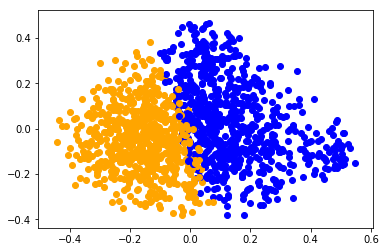

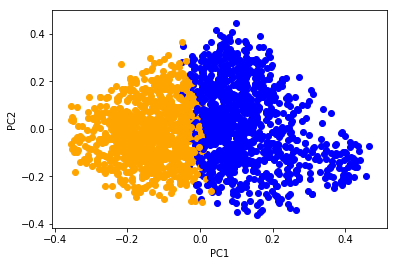

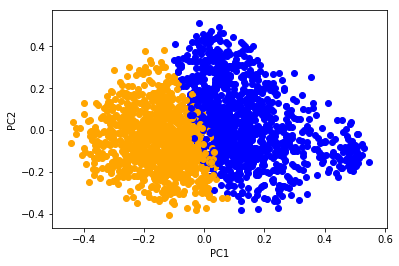

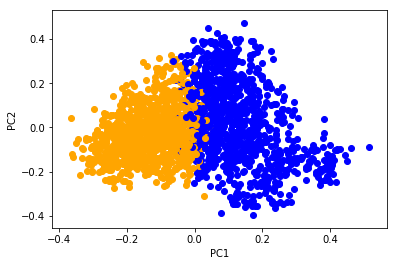

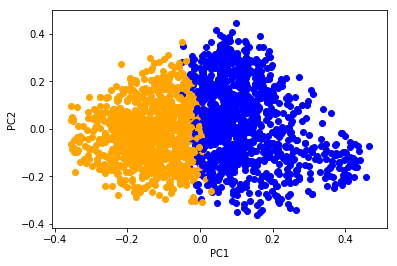

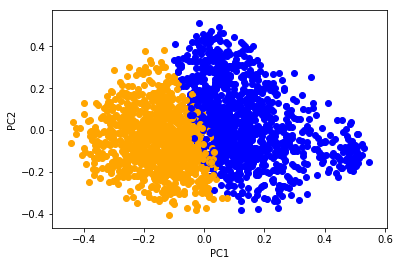

ValueError: object too deep for desired array

In [84]:
visualize_clusters(reduced_vectors_2, freq_nouns, dimensions, annotate, predictions_2)
visualize_clusters(reduced_vectors_5, freq_nouns, dimensions, annotate, predictions_5)
visualize_clusters(reduced_vectors_deps, freq_nouns, dimensions, annotate, predictions_deps)

In [ ]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(v_2_arr)

print (format(time.time()-time_start))